# Computer Vision

## A traffic Monitoring System using Ensemble Machine Learning

    *Name:* Byamugisha Africano
    *Registration No:* 2023/HD05/04595/U
    *Date:* June 05, 2024

## Objectives


## Import necessary libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
import os

import warnings
warnings.filterwarnings("ignore")


## Annotating and Pre-processing Images

The Video was convert to frames with an FPS of 30 using the script as explained [HERE](traffic_monitoring_system\data\01_generate_images_from_video.md)

Manual annotation was done using two tools
1.  LabelImg package as detailed [HERE](traffic_monitoring_system\data\02_setting_up_labelImg.md), which was limiting and the remaining were done using ->
2. Computer Vision Annotation Tool (CVAT) online open source tool, accessed [HERE](https://app.cvat.ai/). 

The data was exported as a CSV file with columns of filename, x_min, y_min, x_max, y_max, and class (truck, motorcycle and other vehicles) as shown in image below
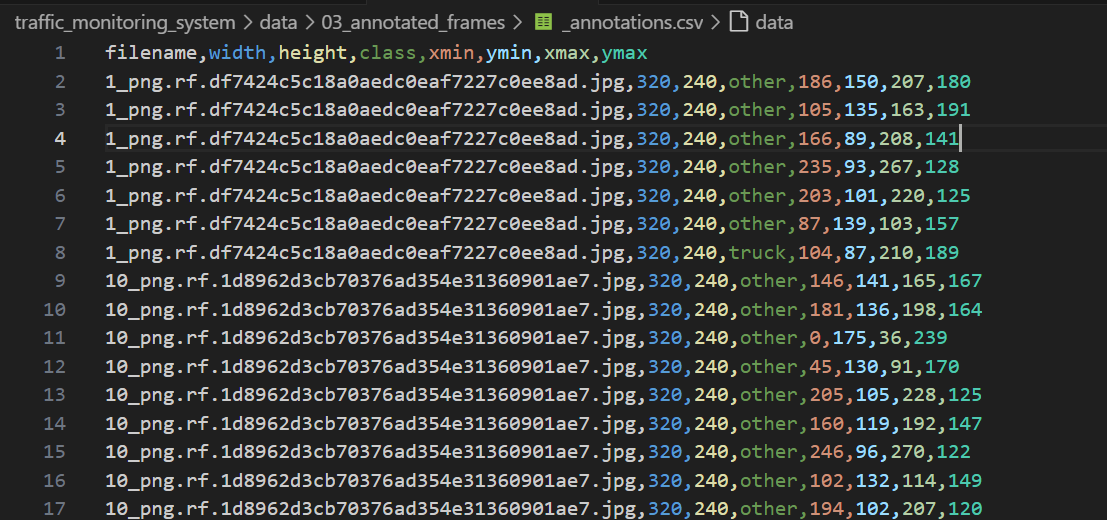

## Loading Annotations

In [19]:
def load_annotations(annotation_path):
    annotations = pd.read_csv(annotation_path)
    return annotations

annotations_path = r'D:\PRSN\Computer_Vision_Cwks\traffic_monitoring_system\data\03_annotated_frames\annotations.csv'  # Replace with actual path

annotations = load_annotations(annotations_path)

## Feature Extraction

In [20]:
def extract_features(image, bbox):
    x_min, y_min, x_max, y_max = bbox
    cropped_image = image[y_min:y_max, x_min:x_max]
    resized_image = cv2.resize(cropped_image, (64, 64))
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    
    # Extract histogram
    hist = cv2.calcHist([gray_image], [0], None, [256], [0, 256]).flatten()
    
    # Extract edges using Canny
    edges = cv2.Canny(gray_image, 100, 200).flatten()
    
    # Combine features
    features = np.hstack((hist, edges))
    return features

## Prepare Dataset

In [22]:
def prepare_dataset(annotations, frame_dir):
    data = []
    labels = []
    
    for _, row in annotations.iterrows():
        filename = row['filename']
        img_path = os.path.join(frame_dir, filename)
        image = cv2.imread(img_path)
        if image is None:
            continue
        bbox = (row['xmin'], row['ymin'], row['xmax'], row['ymax'])
        features = extract_features(image, bbox)
        data.append(features)
        labels.append(row['class'])
    
    return np.array(data), np.array(labels)

frame_dir = r'D:\PRSN\Computer_Vision_Cwks\traffic_monitoring_system\data\03_annotated_frames'

data, labels = prepare_dataset(annotations, frame_dir)


## Training the Machine Learning Models

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)

knn = KNeighborsClassifier()
svm = SVC(probability=True)
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

models = [knn, svm, dt, rf]
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest']

for model in models:
    model.fit(X_train, y_train)

## Evaluation Results

### For KNN model evaluation

In [37]:
name = 'KNN'
model = knn
y_pred = model.predict(X_test)
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 1:  # Check if y_proba has only one dimension
        y_proba = y_proba.reshape(-1, 1)  # Reshape to have two dimensions
else:
    y_proba = model.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation results for KNN model
print(f'{name}:\n')
print(f'Confusion Matrix:\n{pd.DataFrame(cm, columns=model.classes_, index=model.classes_)}\n')
print(f'AUC: {auc}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')


KNN:

Confusion Matrix:
            motorcycle  other  truck
motorcycle           1     20      0
other               29    291      0
truck                0     16      0

AUC: 0.4686175971890258
Precision: 0.7996376532264281
Recall: 0.8179271708683473
F1 Score: 0.8086138719511807



d:\PRSN\computer_vision_cwks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### For SVM model evaluation

In [38]:
# Evaluate SVM Model
name = 'SVM'
model = svm
y_pred = model.predict(X_test)
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 1:  # Check if y_proba has only one dimension
        y_proba = y_proba.reshape(-1, 1)  # Reshape to have two dimensions
else:
    y_proba = model.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')  # Set zero_division='warn'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation results for SVM model
print(f'{name}:\n')
print(f'Confusion Matrix:\n{pd.DataFrame(cm, columns=model.classes_, index=model.classes_)}\n')
print(f'AUC: {auc}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')

SVM:

Confusion Matrix:
            motorcycle  other  truck
motorcycle           0     21      0
other                0    320      0
truck                0     16      0

AUC: 0.9205081748140503
Precision: 0.8034586383573037
Recall: 0.896358543417367
F1 Score: 0.8473699671892391



d:\PRSN\computer_vision_cwks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### For Decision Tree model evaluation:

In [39]:
name = 'Decision Tree'
model = dt
y_pred = model.predict(X_test)
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 1:  # Check if y_proba has only one dimension
        y_proba = y_proba.reshape(-1, 1)  # Reshape to have two dimensions
else:
    y_proba = model.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')  # Set zero_division='warn'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation results for Decision Tree model
print(f'{name}:\n')
print(f'Confusion Matrix:\n{pd.DataFrame(cm, columns=model.classes_, index=model.classes_)}\n')
print(f'AUC: {auc}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')

Decision Tree:

Confusion Matrix:
            motorcycle  other  truck
motorcycle           8     12      1
other               21    293      6
truck                0     11      5

AUC: 0.6507379833488705
Precision: 0.8660185738779725
Recall: 0.8571428571428571
F1 Score: 0.8607200364422499



### For Random Forest model evaluation

In [40]:
name = 'Random Forest'
model = rf
y_pred = model.predict(X_test)
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 1:  # Check if y_proba has only one dimension
        y_proba = y_proba.reshape(-1, 1)  # Reshape to have two dimensions
else:
    y_proba = model.decision_function(X_test)

cm = confusion_matrix(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')  # Set zero_division='warn'
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print evaluation results for Random Forest model
print(f'{name}:\n')
print(f'Confusion Matrix:\n{pd.DataFrame(cm, columns=model.classes_, index=model.classes_)}\n')
print(f'AUC: {auc}\nPrecision: {precision}\nRecall: {recall}\nF1 Score: {f1}\n')

Random Forest:

Confusion Matrix:
            motorcycle  other  truck
motorcycle           1     20      0
other                0    320      0
truck                0     16      0

AUC: 0.8945534858913314
Precision: 0.864539074056589
Recall: 0.8991596638655462
F1 Score: 0.8539710666407498



d:\PRSN\computer_vision_cwks\venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [45]:
import pandas as pd

# Initialize lists to store metrics
model_names = ['KNN', 'SVM', 'Decision Tree', 'Random Forest']
auc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Loop through models to collect metrics
for model, name in zip([knn, svm, dt, rf], model_names):
    y_pred = model.predict(X_test)
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)
        if y_proba.ndim == 1:  # Check if y_proba has only one dimension
            y_proba = y_proba.reshape(-1, 1)  # Reshape to have two dimensions
    else:
        y_proba = model.decision_function(X_test)

    auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
    precision = precision_score(y_test, y_pred, average='weighted', zero_division='warn')  # Set zero_division='warn'
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    # Append scores to respective lists
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Create DataFrame to store metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'AUC': auc_scores,
    'Precision': precision_scores,
    'Recall': recall_scores,
    'F1 Score': f1_scores
})

# Sort the DataFrame by Precision
metrics_df_sorted = metrics_df.sort_values(by='F1 Score', ascending=False)

# Print the sorted DataFrame
print("Metrics for Different Models :\n")
metrics_df_sorted


Metrics for Different Models :



,Model,AUC,Precision,Recall,F1 Score
2,Decision Tree,0.650738,0.866019,0.857143,0.860720
3,Random Forest,0.894553,0.864539,0.899160,0.853971
1,SVM,0.920508,0.803459,0.896359,0.847370
0,KNN,0.468618,0.799638,0.817927,0.808614


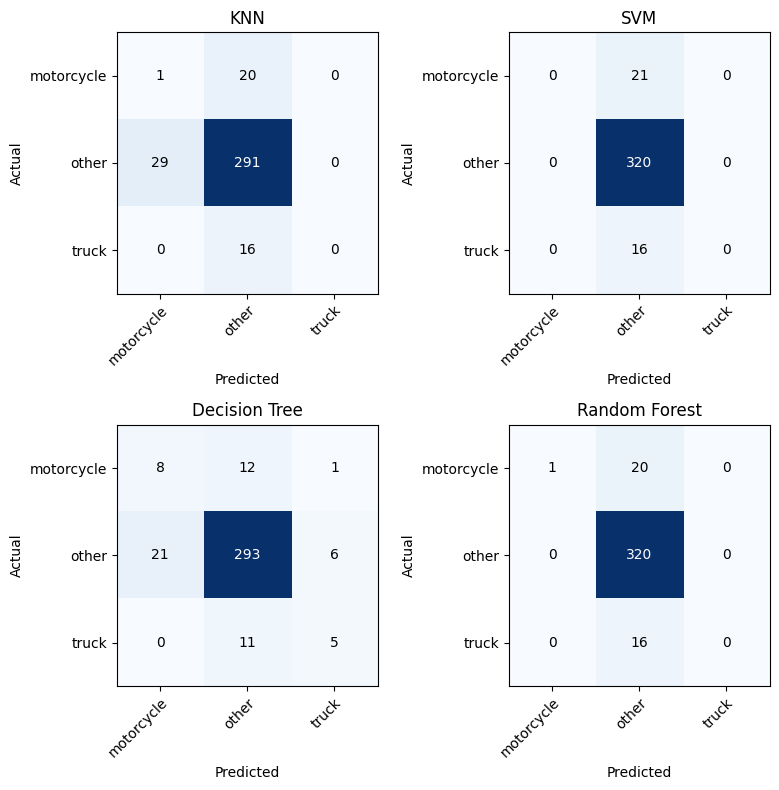

In [51]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

for i, (model, name) in enumerate(zip([knn, svm, dt, rf], model_names)):
    ax = axs[i//2, i%2]
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=model.classes_, yticklabels=model.classes_,
           title=f'{name}',
           xlabel='Predicted',
           ylabel='Actual')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2 else "black")

plt.tight_layout()
plt.show()

ValueError: multiclass format is not supported

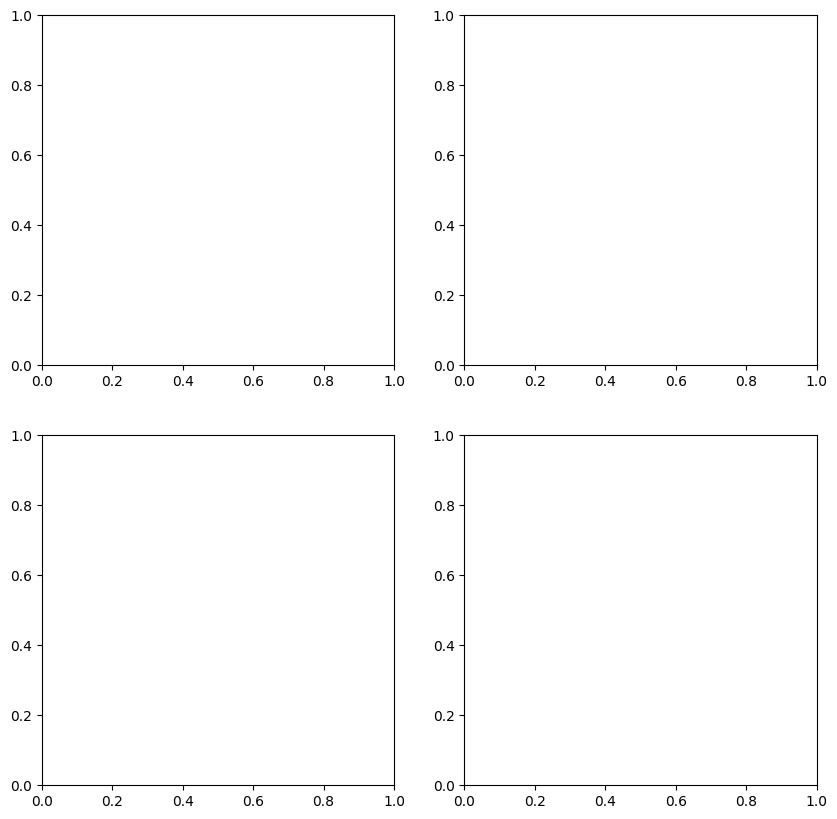

In [54]:
from sklearn.metrics import roc_curve, auc

# Initialize the subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Loop through models to plot ROC curves
for i, (model, name) in enumerate(zip([knn, svm, dt, rf], model_names)):
    ax = axs[i//2, i%2]  # Get the current axis
    
    y_proba = model.predict_proba(X_test)
    if y_proba.ndim == 1:  # Check if y_proba has only one dimension
        y_proba = np.vstack([1 - y_proba, y_proba]).T  # Create probabilities for binary classification
    
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])  # Use y_proba for binary classification
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {name}')
    ax.legend(loc="lower right")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Step 7: Build Ensemble Model
# Assume the best three performing models based on F1 score are selected
best_models = sorted(evaluation_results, key=lambda x: x[5], reverse=True)[:3]
best_model_names = [model[0] for model in best_models]

ensemble_model = VotingClassifier(
    estimators=[(name.lower(), models[model_names.index(name)]) for name in best_model_names], 
    voting='soft'
)
ensemble_model.fit(X_train, y_train)

y_pred_ensemble = ensemble_model.predict(X_test)
y_proba_ensemble = ensemble_model.predict_proba(X_test)[:, 1]

cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)
auc_ensemble = roc_auc_score(y_test, y_proba_ensemble, multi_class='ovr')
precision_ensemble = precision_score(y_test, y_pred_ensemble, average='weighted')
recall_ensemble = recall_score(y_test, y_pred_ensemble, average='weighted')
f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')

print(f'Ensemble Model:\nConfusion Matrix:\n{cm_ensemble}\nAUC: {auc_ensemble}\nPrecision: {precision_ensemble}\nRecall: {recall_ensemble}\nF1 Score: {f1_ensemble}\n')


In [ ]:
# Step 8: Compare Results from Ensemble Model
results = pd.DataFrame(
    [(name, cm, auc, precision, recall, f1) for name, cm, auc, precision, recall, f1 in evaluation_results] +
    [('Ensemble', cm_ensemble, auc_ensemble, precision_ensemble, recall_ensemble, f1_ensemble)],
    columns=['Model', 'Confusion Matrix', 'AUC', 'Precision', 'Recall', 'F1 Score']
)

print(results)